In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
v_val = []
mhinf_val = []
taumh_val = []

for v in range(-100, 0):
    vm = v * 10**-3
    mh_inf = 1 / (1 + np.exp(166.667*(vm+0.070)))
    tau_mh = 0.272 + (1.499 / (1 + np.exp(-114.548*(vm+0.0422))))

    v_val.append(v)
    mhinf_val.append(mh_inf)
    taumh_val.append(tau_mh)

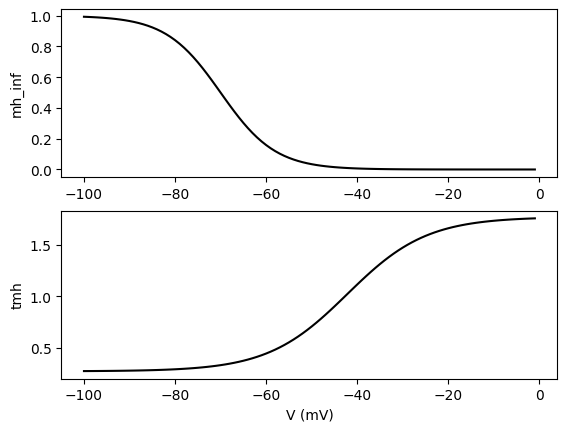

In [9]:
plt.subplot(2,1,1)
plt.plot(v_val, mhinf_val, 'k')
plt.ylabel('mh_inf')

plt.subplot(2,1,2)
plt.plot(v_val, taumh_val, 'k')
plt.ylabel('tmh')
plt.xlabel('V (mV)')
plt.show()